<a href="https://colab.research.google.com/github/Akash-bits/Quora-Question-Pair-Similarity/blob/main/withFuzzyWuzzy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"akashreddy0608","key":"336887cb4e220ac51bf780a850499553"}'}

In [42]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [43]:
!chmod 600 ~/.kaggle/kaggle.json

In [44]:
!kaggle competitions download -c quora-question-pairs
!unzip quora-question-pairs.zip
!unzip train.csv.zip

quora-question-pairs.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  quora-question-pairs.zip
replace sample_submission.csv.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  train.csv.zip
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [2]:
!pip install distance
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [95]:
df=pd.read_csv("train.csv").sample(frac=0.4)
df.shape

(161716, 6)

In [96]:
df.head

<bound method NDFrame.head of             id    qid1    qid2  \
106273  106273  175098  175099   
12496    12496   24073   24074   
160027  160027    6679  141154   
236411  236411  347319  347320   
398845  398845  532091  532092   
...        ...     ...     ...   
39899    39899   72274   72275   
163085  163085  253741  253742   
286741  286741  172581    9356   
77757    77757  132702  132703   
192477  192477  255761  156832   

                                                question1  \
106273  How long after getting my H1B should I wait be...   
12496   Gillian Anderson: Why do you and david beat ar...   
160027      How do I get meth out of my system in 3 days?   
236411   What are the best motivators to get good grades?   
398845  How much jelly would be required to break ones...   
...                                                   ...   
39899   If I ejaculate within a minute while masturbat...   
163085  How should I handle stress and furious behavio...   
286741  Does

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 161716 entries, 106273 to 192477
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            161716 non-null  int64 
 1   qid1          161716 non-null  int64 
 2   qid2          161716 non-null  int64 
 3   question1     161716 non-null  object
 4   question2     161714 non-null  object
 5   is_duplicate  161716 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 8.6+ MB


Number of unique questions =  251989 

Number of repeating questions =  36539 



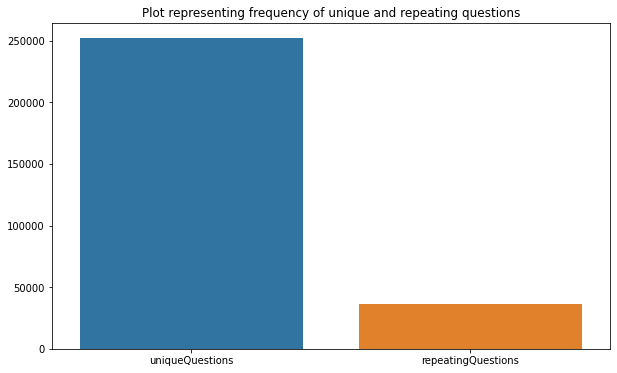

In [98]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unqQids = np. unique(qids)
print('Number of unique questions = ',len(unqQids),"\n")
qidsGrt1=np.sum(qids.value_counts()>1)
print('Number of repeating questions = ',qidsGrt1,"\n")

x = ["uniqueQuestions" , "repeatingQuestions"]
y =  [len(unqQids) , qidsGrt1]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing frequency of unique and repeating questions")
sns.barplot(x,y)
plt.show()

In [99]:
print('rows with is_duplicate = 0 : ',(100 - round(df['is_duplicate'].mean()*100, 2)),'%\n')
print('rows with is_duplicate = 1 : ',(round(df['is_duplicate'].mean()*100, 2)),"%\n")

rows with is_duplicate = 0 :  62.85 %

rows with is_duplicate = 1 :  37.15 %



In the original dataset we had 63.08% and 36.92% , and now we have 62.99% and 37.01% in the sample.<br>
next lets deal with NaN values by dropping the rows.

In [100]:
nullRows = df[df.isnull().any(1)] 
print(nullRows)
df = df.dropna(how="any").reset_index(drop=True)

            id    qid1    qid2                         question1 question2  \
201841  201841  303951  174364  How can I create an Android app?       NaN   
105780  105780  174363  174364    How can I develop android app?       NaN   

        is_duplicate  
201841             0  
105780             0  


In [101]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # replacing certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    #expanding contractipns
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [102]:
df['question1']=df['question1'].apply(preprocess)
df['question2']=df['question2'].apply(preprocess)

**Basic Features** <br>
q1len : number of chars in q1 <br>
q2len : number of chars in q2 <br>
q1wc : number of words in q1 <br>
q2wc : number of words in q2 <br>
commonwc : number of words common between q1 and q2 <br>
cwcRatio : (commonwc) / (number of unique words in question1 + question2) <br>

In [103]:
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()
#df['q1wc'] = df['question1'].str.split(" ").len()
#df['q2wc'] = df['question2'].str.split(" ").len()
df['q1wc'] = df['question1'].apply(lambda x: len(x.split(" ")))
df['q2wc'] = df['question2'].apply(lambda x: len(x.split(" ")))

In [104]:
def commonWordCount(row):
  wordsIn1=set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  wordsIn2=set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
  return len(wordsIn1 & wordsIn2)

df['commonwc'] = df.apply(commonWordCount, axis=1)

In [105]:
def cwcratio(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['cwcRatio'] = df.apply(cwcratio, axis=1)

In [106]:
df

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1wc,q2wc,commonwc,cwcRatio
0,106273,175098,175099,how long after getting my h1b should i wait be...,how long can an h1b holder or his her company...,1,94,101,19,23,10,0.263158
1,12496,24073,24074,gillian anderson why do you and david beat ar...,gillian anderson out of all your roles which ...,0,95,78,21,16,7,0.189189
2,160027,6679,141154,how do i get meth out of my system in 3 days,how do i get meth out of my system faster,1,44,41,12,10,9,0.409091
3,236411,347319,347320,what are the best motivators to get good grades,how can i motivate myself to get good grades,1,47,44,9,9,4,0.222222
4,398845,532091,532092,how much jelly would be required to break ones...,what is a smart environment,0,89,27,16,5,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
161709,39899,72274,72275,if i ejaculate within a minute while masturbat...,i ejaculate within 2 minutes of masturbation ...,0,112,62,20,11,5,0.172414
161710,163085,253741,253742,how should i handle stress and furious behavio...,my ex hesitates when i ask him if he wants to ...,0,140,135,28,32,11,0.200000
161711,286741,172581,9356,does donald trump have any potential to be a g...,why will donald trump be a good president,1,59,41,11,8,6,0.315789
161712,77757,132702,132703,which graphic is better quadro k5000 or gtx 10...,why is there no i and o row in the theaters,0,85,47,17,15,2,0.068966


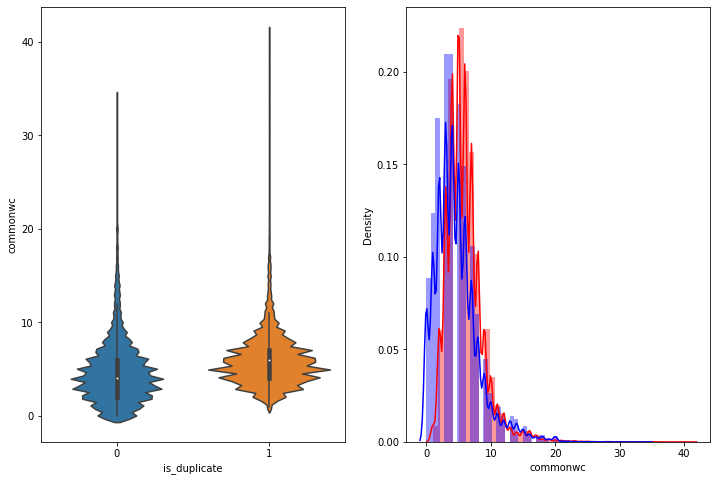

In [107]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'commonwc', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['commonwc'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['commonwc'][0:] , label = "0" , color = 'blue' )
plt.show()

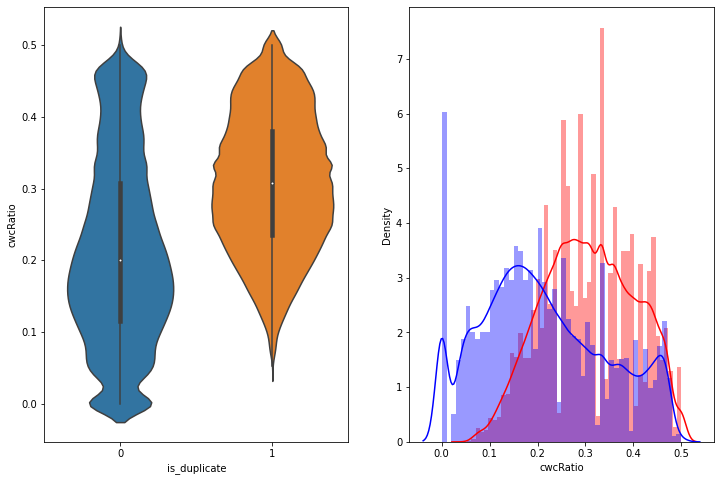

In [108]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'cwcRatio', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['cwcRatio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['cwcRatio'][0:] , label = "0" , color = 'blue' )
plt.show()

**Adding NLP features**

In [109]:
import spacy
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))
#encoding to unicode

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#get list of all questions
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)

word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [111]:
!python -m spacy download en_core_web_lg
!python -m spacy download en

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 400.7 MB 4.7 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 16.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [112]:
from tqdm import tqdm

In [113]:
nlp = spacy.load('en_core_web_lg')
vecs1 = []

for q1 in tqdm(list(df['question1'])):
    doc1 = nlp(q1) 
    mean_vec1 = np.zeros([len(doc1), 300])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)

100%|██████████| 161714/161714 [23:56<00:00, 112.58it/s]


In [114]:
vecs2 = []
for q2 in tqdm(list(df['question2'])):
    doc2 = nlp(q2) 
    mean_vec2 = np.zeros([len(doc2), 300])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 161714/161714 [23:18<00:00, 115.67it/s]


In [3]:
import pickle

In [131]:
pickle.dump(tfidf,open('tfidf.pkl','wb'))

In [133]:
pickle.dump(word2tfidf,open('word2tfidf.pkl','wb'))

**Fuzzy Features**<br>
Fuzz ratio<br>
Fuzz partial ratio<br>
token sort ratio<br>
token set ratio


In [4]:
pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
from fuzzywuzzy import fuzz
def fetch_fuzzy_features(row):
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



In [117]:
fuzzy_features = df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [118]:
df

,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1wc,q2wc,commonwc,cwcRatio,q1_feats_m,q2_feats_m,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,106273,175098,175099,how long after getting my h1b should i wait be...,how long can an h1b holder or his her company...,1,94,101,19,23,10,0.263158,"[-7.851042840629816, 0.2713748700916767, -35.2...","[-7.89687529951334, 1.5708334930241108, -34.29...",51,53,55,64
1,12496,24073,24074,gillian anderson why do you and david beat ar...,gillian anderson out of all your roles which ...,0,95,78,21,16,7,0.189189,"[-33.970734377391636, 14.843695593997836, -15....","[-6.539615765213966, 10.733477801084518, -13.1...",37,46,53,59
2,160027,6679,141154,how do i get meth out of my system in 3 days,how do i get meth out of my system faster,1,44,41,12,10,9,0.409091,"[-4.94098112359643, 10.019466400146484, -3.200...","[-10.144482050091028, 7.519007967785001, -6.78...",87,85,80,91
3,236411,347319,347320,what are the best motivators to get good grades,how can i motivate myself to get good grades,1,47,44,9,9,4,0.222222,"[-14.245931379497051, 13.940406396985054, -1.1...","[-9.82232815027237, 10.90574492700398, -10.613...",68,72,66,68
4,398845,532091,532092,how much jelly would be required to break ones...,what is a smart environment,0,89,27,16,5,0,0.000000,"[3.6972643956542015, -4.90280282497406, -3.315...","[-2.4540202990174294, 1.709061399102211, -0.60...",19,41,24,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161709,39899,72274,72275,if i ejaculate within a minute while masturbat...,i ejaculate within 2 minutes of masturbation ...,0,112,62,20,11,5,0.172414,"[-21.76795443147421, 16.553846433758736, -19.0...","[-6.634148105978966, 2.287705644965172, -5.936...",62,81,58,61
161710,163085,253741,253742,how should i handle stress and furious behavio...,my ex hesitates when i ask him if he wants to ...,0,140,135,28,32,11,0.200000,"[-35.445088962020236, 45.171433076262474, -28....","[-9.432946130633354, 37.16419541463256, -40.46...",33,44,54,57
161711,286741,172581,9356,does donald trump have any potential to be a g...,why will donald trump be a good president,1,59,41,11,8,6,0.315789,"[-5.2402793020009995, 12.986592024564743, -4.2...","[-4.749088607728481, 9.687691152095795, 3.4219...",66,66,64,88
161712,77757,132702,132703,which graphic is better quadro k5000 or gtx 10...,why is there no i and o row in the theaters,0,85,47,17,15,2,0.068966,"[13.326158121228218, 22.230661183595657, 15.03...","[13.455414786934853, 1.860436737537384, -0.262...",17,28,28,27


In [119]:
df.to_csv('Features2.csv')

In [120]:
import shutil
colab_link = "/content/Features2.csv"
gdrive_link = "/content/drive/MyDrive/Quora Question Pair Similarity/"
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/Quora Question Pair Similarity/Features2.csv'

In [61]:
import shutil

In [79]:
df=pd.read_csv('Features2.csv')


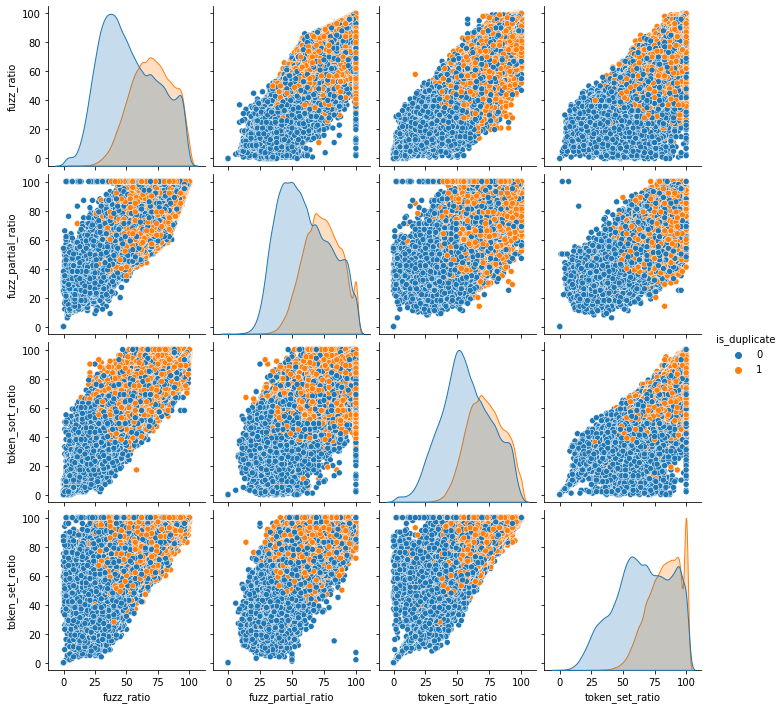

In [121]:
sns.pairplot(df[['fuzz_ratio', 'fuzz_partial_ratio','token_sort_ratio','token_set_ratio', 'is_duplicate']],hue='is_duplicate')

These new features appear to provide much more separability between the 2 classes.

In [123]:
df=df.drop(['qid1','qid2','question1','question2'],axis=1)
df=df.dropna()
df.head()

,id,is_duplicate,q1len,q2len,q1wc,q2wc,commonwc,cwcRatio,q1_feats_m,q2_feats_m,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,106273,1,94,101,19,23,10,0.263158,"[-7.851042840629816, 0.2713748700916767, -35.2...","[-7.89687529951334, 1.5708334930241108, -34.29...",51,53,55,64
1,12496,0,95,78,21,16,7,0.189189,"[-33.970734377391636, 14.843695593997836, -15....","[-6.539615765213966, 10.733477801084518, -13.1...",37,46,53,59
2,160027,1,44,41,12,10,9,0.409091,"[-4.94098112359643, 10.019466400146484, -3.200...","[-10.144482050091028, 7.519007967785001, -6.78...",87,85,80,91
3,236411,1,47,44,9,9,4,0.222222,"[-14.245931379497051, 13.940406396985054, -1.1...","[-9.82232815027237, 10.90574492700398, -10.613...",68,72,66,68
4,398845,0,89,27,16,5,0,0.000000,"[3.6972643956542015, -4.90280282497406, -3.315...","[-2.4540202990174294, 1.709061399102211, -0.60...",19,41,24,24


In [83]:
df.drop(['Unnamed: 0'],axis=1)
df.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,q1len,q2len,q1wc,q2wc,commonwc,cwcRatio,q1_feats_m,q2_feats_m,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
0,0,326174,240018,222844,what was the worst experience you had with a p...,what is the worst experience you have had with...,1,59,63,11,12,10,0.434783,[-7.48163170e+00 1.04856268e+01 2.45296118e+...,[-7.30199259e+00 1.04611746e+01 3.67595403e-...,93,90,90,96
1,1,342346,470321,470322,in willy wonka and the chocolate factory what...,what is the cause of black death,0,138,32,27,7,2,0.071429,[ 3.78397314e+01 2.15407461e+01 6.07592978e+...,[-5.48714919e+00 8.28602656e+00 -4.18013930e+...,20,41,24,40
2,2,378425,509817,509818,what is the most interesting island to visit i...,what are some best islands to visit for a hone...,0,82,51,16,10,3,0.120000,[ 26.27955554 -12.05344534 -9.14137963 9.47...,[ 9.03331213e+00 -2.82600497e+00 -9.11594719e-...,53,63,52,53
3,3,285562,406002,406003,i am going to be 30 this year all my friends ...,what is the worst problem of the united states...,0,127,52,28,10,0,0.000000,[ 3.93202532e+00 2.72085138e+01 -2.25993561e+...,[-8.32440103e+00 9.53146876e+00 3.87070881e+...,26,38,29,32
4,4,117015,190500,190501,i want to go to a new one month fitness cent...,i am going to a water park with my friends but...,0,130,178,31,42,9,0.157895,[ 9.88252350e+00 2.46135149e+01 -2.17332158e+...,[ 9.99852847e-01 3.59913331e+01 -4.38569093e+...,40,40,49,48


In [124]:
#df1 = df.drop(['qid1','qid2','question1','question2'],axis=1)

In [125]:
df1_q1 = pd.DataFrame(df.q1_feats_m.values.tolist(), index = df.index)
df1_q2 = pd.DataFrame(df.q2_feats_m.values.tolist(), index = df.index)

In [126]:
df1_q1['id'] = df['id']
df1_q2['id'] = df['id']
df = df.merge(df1_q1, on='id',how='left')
df = df.merge(df1_q2, on='id', how='left')
df.head()

,id,is_duplicate,q1len,q2len,q1wc,q2wc,commonwc,cwcRatio,q1_feats_m,q2_feats_m,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,106273,1,94,101,19,23,10,0.263158,"[-7.851042840629816, 0.2713748700916767, -35.2...","[-7.89687529951334, 1.5708334930241108, -34.29...",...,-17.256585,19.209471,5.613915,-20.793081,8.541976,-16.291737,10.881659,27.182190,9.352088,24.390003
1,12496,0,95,78,21,16,7,0.189189,"[-33.970734377391636, 14.843695593997836, -15....","[-6.539615765213966, 10.733477801084518, -13.1...",...,0.622341,3.882244,-6.651935,-2.289627,4.071302,6.913015,0.320845,-12.298625,7.510157,-2.879857
2,160027,1,44,41,12,10,9,0.409091,"[-4.94098112359643, 10.019466400146484, -3.200...","[-10.144482050091028, 7.519007967785001, -6.78...",...,-16.500945,-6.702809,8.984507,6.506029,-6.617587,-1.658257,-0.862851,6.135561,-1.373182,11.434897
3,236411,1,47,44,9,9,4,0.222222,"[-14.245931379497051, 13.940406396985054, -1.1...","[-9.82232815027237, 10.90574492700398, -10.613...",...,-4.366335,2.635414,0.462144,5.621552,5.569076,3.360483,4.042835,-3.134133,4.600932,0.655209
4,398845,0,89,27,16,5,0,0.000000,"[3.6972643956542015, -4.90280282497406, -3.315...","[-2.4540202990174294, 1.709061399102211, -0.60...",...,-5.516746,1.952477,-0.980471,0.600385,1.991567,5.091191,2.171970,2.430315,-4.213938,1.195563


In [128]:
df.to_csv('Features3.csv')

In [129]:
colab_link = "/content/Features3.csv"
gdrive_link = "/content/drive/MyDrive/Quora Question Pair Similarity/"
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/Quora Question Pair Similarity/Features3.csv'

In [134]:
df1 = df.dropna()
y_data = df1['is_duplicate']#.astype(float)
df1.drop(['q1_feats_m','q2_feats_m','id','is_duplicate'], axis=1, inplace=True)

In [135]:
df1.head()

,q1len,q2len,q1wc,q2wc,commonwc,cwcRatio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,94,101,19,23,10,0.263158,51,53,55,64,...,-17.256585,19.209471,5.613915,-20.793081,8.541976,-16.291737,10.881659,27.182190,9.352088,24.390003
1,95,78,21,16,7,0.189189,37,46,53,59,...,0.622341,3.882244,-6.651935,-2.289627,4.071302,6.913015,0.320845,-12.298625,7.510157,-2.879857
2,44,41,12,10,9,0.409091,87,85,80,91,...,-16.500945,-6.702809,8.984507,6.506029,-6.617587,-1.658257,-0.862851,6.135561,-1.373182,11.434897
3,47,44,9,9,4,0.222222,68,72,66,68,...,-4.366335,2.635414,0.462144,5.621552,5.569076,3.360483,4.042835,-3.134133,4.600932,0.655209
4,89,27,16,5,0,0.000000,19,41,24,24,...,-5.516746,1.952477,-0.980471,0.600385,1.991567,5.091191,2.171970,2.430315,-4.213938,1.195563


In [136]:
df1.to_csv('Features4x.csv')
y_data.to_csv('Features4y.csv')

In [137]:
colab_link = "/content/Features4x.csv"
gdrive_link = "/content/drive/MyDrive/Quora Question Pair Similarity/"
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/Quora Question Pair Similarity/Features4x.csv'

In [138]:
colab_link = "/content/Features4y.csv"
gdrive_link = "/content/drive/MyDrive/Quora Question Pair Similarity/"
shutil.copy(colab_link, gdrive_link)

'/content/drive/MyDrive/Quora Question Pair Similarity/Features4y.csv'

In [7]:
y1trial =pd.read_csv('Features4y.csv')

In [8]:
y1trial.head()

,Unnamed: 0,is_duplicate
0,0,1
1,1,0
2,2,1
3,3,1
4,4,0


In [6]:
#del y1trial
x1trial = pd.read_csv('Features4x.csv')
x1trial.head()

,Unnamed: 0,q1len,q2len,q1wc,q2wc,commonwc,cwcRatio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,94,101,19,23,10,0.263158,51,53,55,...,-17.256585,19.209471,5.613915,-20.793081,8.541976,-16.291737,10.881659,27.182190,9.352088,24.390003
1,1,95,78,21,16,7,0.189189,37,46,53,...,0.622341,3.882244,-6.651935,-2.289627,4.071302,6.913015,0.320845,-12.298625,7.510157,-2.879857
2,2,44,41,12,10,9,0.409091,87,85,80,...,-16.500945,-6.702809,8.984507,6.506029,-6.617587,-1.658257,-0.862851,6.135561,-1.373182,11.434897
3,3,47,44,9,9,4,0.222222,68,72,66,...,-4.366335,2.635414,0.462144,5.621552,5.569076,3.360483,4.042835,-3.134133,4.600932,0.655209
4,4,89,27,16,5,0,0.000000,19,41,24,...,-5.516746,1.952477,-0.980471,0.600385,1.991567,5.091191,2.171970,2.430315,-4.213938,1.195563


In [9]:
df1 = x1trial.drop(['Unnamed: 0'], axis=1, inplace=True)
y_data = y1trial.drop(['Unnamed: 0'], axis=1, inplace=True)

In [14]:
x1trial.head()

,q1len,q2len,q1wc,q2wc,commonwc,cwcRatio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,94,101,19,23,10,0.263158,51,53,55,64,...,-17.256585,19.209471,5.613915,-20.793081,8.541976,-16.291737,10.881659,27.182190,9.352088,24.390003
1,95,78,21,16,7,0.189189,37,46,53,59,...,0.622341,3.882244,-6.651935,-2.289627,4.071302,6.913015,0.320845,-12.298625,7.510157,-2.879857
2,44,41,12,10,9,0.409091,87,85,80,91,...,-16.500945,-6.702809,8.984507,6.506029,-6.617587,-1.658257,-0.862851,6.135561,-1.373182,11.434897
3,47,44,9,9,4,0.222222,68,72,66,68,...,-4.366335,2.635414,0.462144,5.621552,5.569076,3.360483,4.042835,-3.134133,4.600932,0.655209
4,89,27,16,5,0,0.000000,19,41,24,24,...,-5.516746,1.952477,-0.980471,0.600385,1.991567,5.091191,2.171970,2.430315,-4.213938,1.195563


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import warnings
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [15]:
x_train,x_test, y_train, y_test = train_test_split(x1trial, y1trial, stratify=y1trial, test_size=0.3)

In [16]:
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)

LogisticRegression()

In [85]:
logloss = log_loss(y_test, logisticRegr.predict_proba(x_test))
print(logloss)

0.5193234967878839


In [86]:
accur = logisticRegr.score(x_test, y_test)
print(accur)

0.7218889782120257


In [17]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

In [18]:
rf.fit(x_train,y_train)

RandomForestClassifier()

In [88]:
y_pred = rf.predict(x_test)
accuracy_score(y_test,y_pred)

0.7868568601583114

In [89]:
confusion_matrix(y_test,y_pred)

array([[26787,  3701],
       [ 6639, 11385]])

In [90]:
logloss = log_loss(y_test, rf.predict_proba(x_test))
print(logloss)

0.447370525269599


In [91]:
pickle.dump(rf,open('model.pkl','wb'))

In [92]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

In [93]:
xgb.fit(x_train,y_train)

XGBClassifier()

In [98]:
y_pred = xgb.predict(x_test)
accuracy_score(y_test,y_pred)

0.7475728155339806

In [99]:
confusion_matrix(y_test,y_pred)

array([[24393,  6222],
       [ 6024, 11874]])

In [95]:
logloss = log_loss(y_test, xgb.predict_proba(x_test))
print(logloss)

0.47787999669446696


From accuracy point of view as well as from cost of misclassifying as duplicate when not , **random forest** is the best model of the three. 

In [20]:
def preprocess1(q):
    
    q = str(q).lower().strip()
    
    # replacing certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    #expanding contractipns
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [21]:
!pip install spacy
!python -m spacy download en
import spacy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 22.4 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [22]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction.text import CountVectorizer
# #get list of all questions
# questions = list(df['question1']) + list(df['question2'])

# tfidf = TfidfVectorizer(lowercase=False, )
# tfidf.fit_transform(questions)

# # dict key:word and value:tf-idf score
# word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [92]:
def countCommonWords(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return len(w1 & w2)

In [93]:
def totalNumberOfWords(q1,q2):
    w1 = set(map(lambda word: word.lower().strip(), q1.split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), q2.split(" ")))    
    return (len(w1) + len(w2))

In [94]:
def findFuzzyFeatures(q1,q2):
    fuzzyFeatures = [0.0]*4
    fuzzyFeatures[0] = fuzz.QRatio(q1, q2)
    fuzzyFeatures[1] = fuzz.partial_ratio(q1, q2)
    fuzzyFeatures[2] = fuzz.token_sort_ratio(q1, q2)
    fuzzyFeatures[3] = fuzz.token_set_ratio(q1, q2)
    return fuzzyFeatures

In [95]:
def findW2vector(q):
  nlp = spacy.load('en_core_web_lg')
  pickle_off = open("word2tfidf.pkl","rb")
  word2tfidf = pickle.load(pickle_off)
  #print(emp)
  vecs1 = []
  #for qu1 in tqdm(list(df['question1'])):
  doc1 = nlp(q) 
      # 384 is the number of dimensions of vectors 
  mean_vec1 = np.zeros([len(doc1), 300])
  for word1 in doc1:
          # word2vec
      vec1 = word1.vector
          # fetch df score
      try:
          idf = word2tfidf[str(word1)]
      except:
          idf = 0
          # compute final vec
      #print(idf)    
      mean_vec1 += vec1 * idf
  mean_vec1 = mean_vec1.mean(axis=0)
  vecs1.append(mean_vec1)
  #print(mean_vec1)
  #return list(vecs1)
  return list(mean_vec1)


In [63]:
findW2vector('What is this')

[-0.6181890815496445,
 2.8354381322860718,
 0.3260833537206054,
 1.1220189929008484,
 -0.5453366637229919,
 -0.8128751814365387,
 -0.4733961224555969,
 -1.918230652809143,
 0.08697301894426346,
 17.720192432403564,
 -1.9263166431337595,
 0.18739242106676102,
 -0.015862345695495605,
 0.16774218995124102,
 -0.7805474549531937,
 -0.8748246426694095,
 -0.267850823700428,
 8.936067342758179,
 -0.348711721599102,
 -0.43729017674922943,
 -0.03613632917404175,
 -1.3542670011520386,
 0.7004659473896027,
 0.45231263898313046,
 -0.8787537217140198,
 1.2475898563861847,
 -0.6967247948050499,
 -0.5573496893048286,
 -2.4988306760787964,
 0.5145358964800835,
 0.13456052541732788,
 1.827301636338234,
 0.40641123056411743,
 -1.7241217866539955,
 -0.8446604907512665,
 0.09801746974699199,
 -0.1600563619285822,
 -1.7228578925132751,
 -0.4254781608469784,
 -2.365378499031067,
 -0.06711357831954956,
 1.9901315569877625,
 1.4252794682979584,
 -0.10218346118927002,
 -0.703082799911499,
 1.2288480401039124,
 

In [96]:
def computeQueryPoint(q1,q2):
    query = []

    q1 = preprocess1(q1)
    q2 = preprocess1(q2)
    
    #basic features of the query - 7
    query.append(len(q1))
    query.append(len(q2))
    query.append(len(q1.split(" ")))
    query.append(len(q2.split(" ")))
    query.append(countCommonWords(q1,q2))
    # query.append(totalNumberOfWords(q1,q2))
    query.append(round(countCommonWords(q1,q2)/totalNumberOfWords(q1,q2),2))
    
    # fetch fuzzy features - 4
    fuzzyFeatures = findFuzzyFeatures(q1,q2)
    query.extend(fuzzyFeatures)
    
    # nlp features
    #q1w2v = np.array(findW2vector(q1))
    #q2w2v = np.array(findW2vector(q2))
    q1w2v = findW2vector(q1)
    q2w2v = findW2vector(q2)
    
    #return np.hstack((np.array(query).reshape(1,11),q1w2v,q2w2v))
    query.extend(q1w2v)
    query.extend(q2w2v)
    return query

In [67]:
computeQueryPoint('how r u', 'how r you')

[7,
 9,
 3,
 3,
 2,
 0.33,
 88,
 86,
 88,
 88,
 -0.5371487140655518,
 1.0987879037857056,
 -0.8857340216636658,
 0.005149960517883301,
 -0.24289166927337646,
 0.2687942683696747,
 -0.11632087081670761,
 0.2992338240146637,
 0.20286649465560913,
 6.108981132507324,
 -0.8581184148788452,
 -0.6819392442703247,
 -0.2944885194301605,
 -0.08571230620145798,
 -0.3232382833957672,
 -0.22804918885231018,
 -0.5255515575408936,
 2.836552381515503,
 -1.0145061016082764,
 -0.9810804724693298,
 1.1408478021621704,
 -0.5396718382835388,
 0.22660012543201447,
 -0.6375414729118347,
 -0.6153425574302673,
 0.3360622525215149,
 -0.024657219648361206,
 0.256178617477417,
 0.3732841908931732,
 -0.9881406426429749,
 -0.7168464064598083,
 0.29569217562675476,
 0.2211441546678543,
 -0.11625143140554428,
 0.617518424987793,
 0.34307610988616943,
 0.4121496379375458,
 0.2048780769109726,
 -0.8365214467048645,
 -0.48768144845962524,
 -0.6115694046020508,
 -0.6951335668563843,
 0.4091172516345978,
 -0.480112075805

In [97]:
pickle_off = open("model.pkl","rb")
rf = pickle.load(pickle_off)

In [98]:
rf.predict(np.array(computeQueryPoint('how r u', 'how r you')).reshape(1,-1))

array([0])

In [ ]:
rf.predict(np.array(computeQueryPoint('who is the current prime minister of india ?', 'hi, who is the prime minister of india ?')).reshape(1,-1))

array([1])

In [75]:
rf.predict(np.array(computeQueryPoint('What is the name of John\'s dog', 'What is the name of John\'s pet')).reshape(1,-1))

array([0])

In [84]:
ques1 = 'Where is the capital city of India?'
ques2 = 'What is the current capital of Pakistan?'
ques3 = 'Which city is the capital of India?'
ques4 = 'What is the business capital of India?'

In [80]:
rf.predict(np.array(computeQueryPoint(ques1, ques4)).reshape(1,-1))

array([0])

In [87]:
rf.predict(np.array(computeQueryPoint(ques1, ques1)).reshape(1,-1))

array([1])